In [1]:
import numpy as np 
from scipy import optimize
import pandas as pd
import uproot
import matplotlib.pyplot as plt

In [2]:
# Try Daarii's input root file

infile = uproot.open('qcd_JZ3_12_phys_boosted.root')
#infile.keys()

In [13]:
dhist = infile['D_GN2Xv01_vs_mj_inc_J1']
vals, mass_bins, gn2x_bins = dhist.to_numpy()


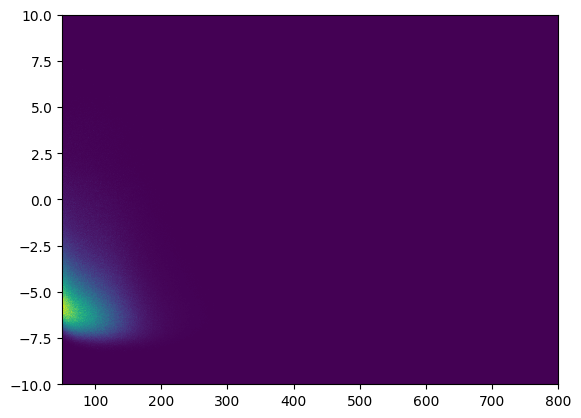

In [26]:
fig,ax = plt.subplots(1,1)
plt.pcolor(mass_bins, gn2x_bins , vals.T)

In [71]:
### Define function to calculate the efficiency for a given subset of data 

def cuteff( cutval, *args ): #discs , wgts , targeteff ): 
    
    gn2x_bins, myhisto, targeteff = args
    roundedcut = np.argmin(np.abs(gn2x_bins-cutval))

    # calculate number of events "passing" the GN2X cut (discriminant > the cut value) 
    # divided by total number of events 
    eff = np.sum(myhisto[roundedcut:]) / np.sum(myhisto)
    delta_eff = eff - targeteff 
    
    return delta_eff 

In [72]:
vals.shape , vals[0,:].shape

((750, 6000), (6000,))

In [139]:
# First, find the optimal cut value per bin, looping over all Daarii's rejection %s 

guessval = 4. 

wps = [ 0.0025, 0.003, 0.0037, 0.0046, 0.0058, 0.0074, 0.0094, 0.0125, 0.0155 ]

# array to store the cut values (format: (nominal, up, down) cut for each bin, for each WP)
cutvals = np.zeros((len(wps),len(mass_bins)-1,3))

for iwp,wp in enumerate(wps): 
    for imbin in range(len(mass_bins)-1): 
        slice_vals = vals[imbin,:]

        # First, get the optimal cut value (nominal)
        optcut = optimize.root(
            cuteff, # input function to find the root of 
            x0=[guessval], # initial guess of the cut value we want 
            args=(gn2x_bins, slice_vals, wp), # other arguments to cuteff (not to be optimized)
            tol = gn2x_bins[1]-gn2x_bins[0]  # tolerance; we're limited by the histo bin size
        )

        # Next, get the stat error (binomial) on the cut 
        swpass = np.sum(slice_vals[roundedcut:])
        swtotal = np.sum(slice_vals)
        err = np.sqrt( swpass*(swtotal - swpass) / swtotal**3 )

        #if(imbin<10): print(optcut.x, err)   # just for debugging 

        optcut_up = optimize.root(
            cuteff, # input function to find the root of 
            x0=[4], # initial guess of the cut value we want 
            args=(gn2x_bins, slice_vals, wp+err), # other arguments to cuteff (not to be optimized)
            tol = gn2x_bins[1]-gn2x_bins[0]  # tolerance; we're limited by the histo bin size
        )

        optcut_down = optimize.root(
            cuteff, # input function to find the root of 
            x0=[4], # initial guess of the cut value we want 
            args=(gn2x_bins, slice_vals, wp-err), # other arguments to cuteff (not to be optimized)
            tol = gn2x_bins[1]-gn2x_bins[0]  # tolerance; we're limited by the histo bin size
        )

        # The error sometimes gets fudged due to rounding from the binning. If this is the case, symmetrize and use the larger error 
        # also note that "uperr" will be a lower GN2X cut (it corresponds to having more events pass the cut) 
        nomcut = optcut.x 
        uperr = optcut_up.x - nomcut 
        downerr = nomcut - optcut_down.x 
        #if( (uperr<0) or (downerr<0) ): 
        symerr = np.max(np.abs([uperr,downerr]))
        uperr = symerr
        downerr = symerr


        cutvals[iwp][imbin][0] = nomcut
        cutvals[iwp][imbin][1] = uperr
        cutvals[iwp][imbin][2] = downerr
        
        guessval = nomcut

        
#         # Plot the new WP as a function of mass
#         plt.plot(mass_bins[:-1], cutvals[:,0], 'b.')
#         plt.errorbar(mass_bins[:-1], cutvals[:,0], yerr=np.vstack((cutvals[:,1],cutvals[:,2])), color='b')
#         ax.set_xscale('log') 
        


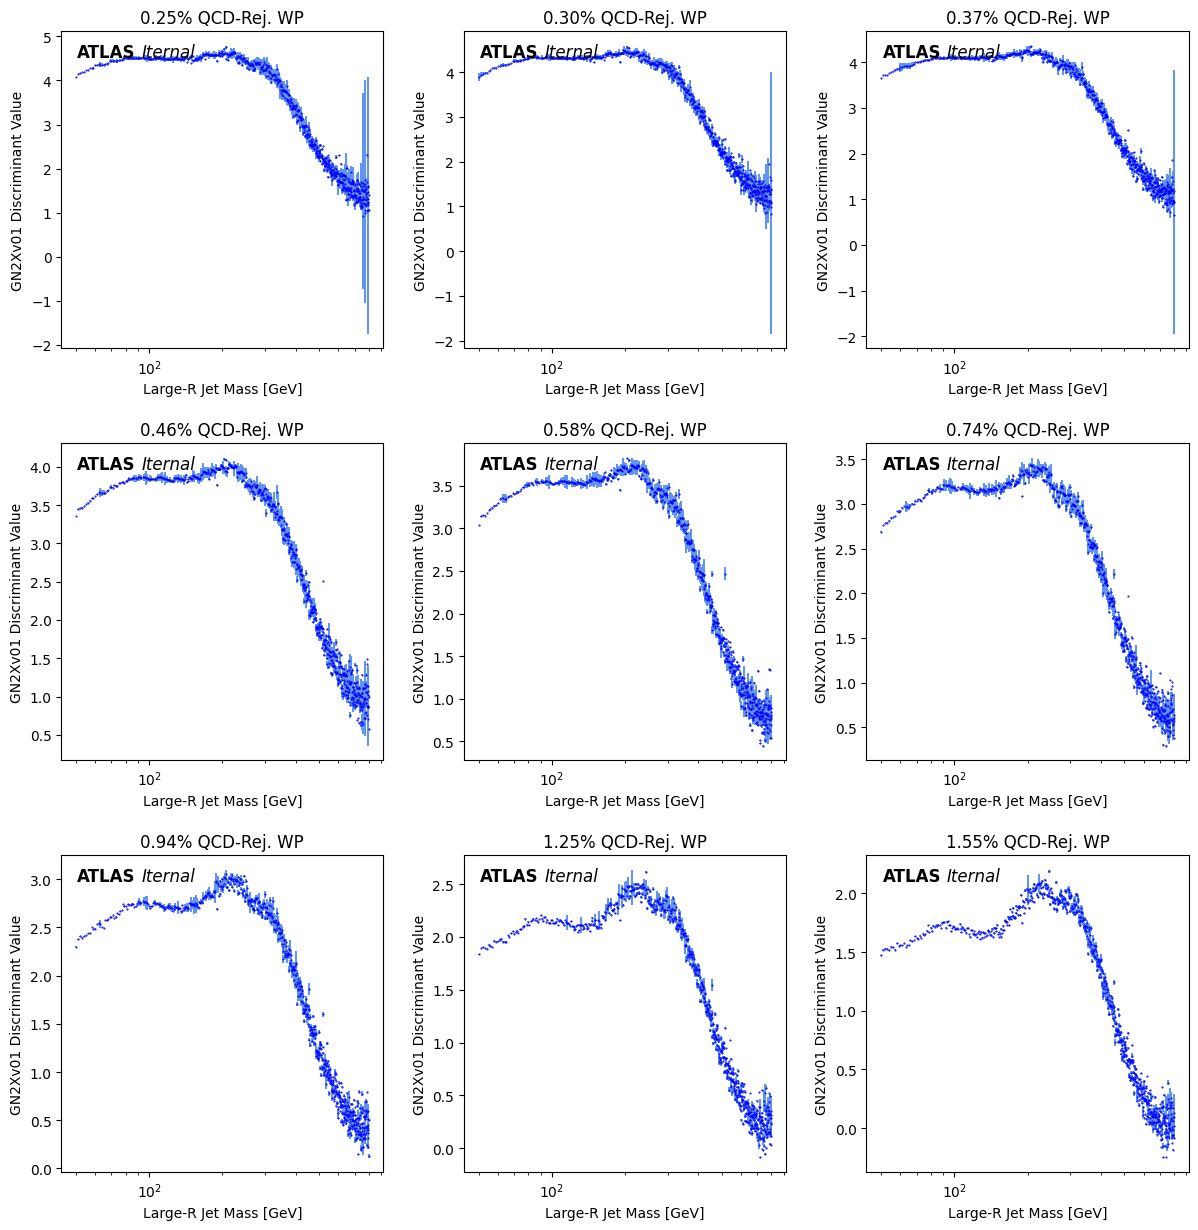

In [140]:
# define figure for plotting 
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
fig.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.3)
irow = 0
icol = 0

for iwp,wp in enumerate(wps): 

    ### Make a nice plot of this WP cut as a function of mass 

    # plot the original discriminant values 
    ax[irow,icol].errorbar(mass_bins[:-1], cutvals[iwp][:,0], yerr=np.vstack((cutvals[iwp][:,1],cutvals[iwp][:,2])), ecolor='cornflowerblue', fmt='none')
    ax[irow,icol].plot( mass_bins[:-1], cutvals[iwp][:,0], marker='.', color='b', markersize=1, linewidth=0, label='Disc. Value')

    # fix the WP label by hand in case the rounding is weird 
    ax[irow,icol].set_title(f"{float(str(100.*wp).replace('%','')):1.2f}% QCD-Rej. WP")
    ax[irow,icol].set_xlabel('Large-R Jet Mass [GeV]')
    ax[irow,icol].set_ylabel('GN2Xv01 Discriminant Value')
    ax[irow,icol].set_xscale('log')
    #ax[irow,icol].legend()

    ax[irow,icol].text(s="ATLAS",fontweight='bold',x=0.05,y=0.92,transform=ax[irow,icol].transAxes,size='large')
    ax[irow,icol].text(s="Iternal",fontstyle='italic',x=0.25,y=0.92,transform=ax[irow,icol].transAxes,size='large')


    # Update the plot col/row iterators 
    icol += 1 
    if icol>=3: 
        irow += 1
        icol = 0 
